# <center> CIFAR-10 </center>

by Hyr1sky_He

## 1. Env Preperations

In [45]:
import numpy as np
import pandas as pd
import time
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
%matplotlib inline

# Constants
IMAGE_SIZE = 32
NUM_CLASSES = 10
COLOR_CHANNELS = 3

# Check CUDA
CUDA = torch.cuda.is_available()
print('CUDA is available:', CUDA)

CUDA is available: True


## 2. Transform

the values used in `Normalization` is copied from LiMu's Class

In [79]:
train_tfm = transforms.Compose([
    torchvision.transforms.Resize(40),
    # only keep R channel
    torchvision.transforms.Lambda(lambda x: x.convert('L')),
    torchvision.transforms.RandomResizedCrop(32,scale=(0.64,1.0),ratio=(1.0,1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize([0.4914,0.4822,0.4465],
                                     # [0.2023,0.1994,0.2010])
])

test_tfm = transforms.Compose([
    torchvision.transforms.Resize(40),
    # only keep R channel
    torchvision.transforms.Lambda(lambda x: x.convert('L')),
    transforms.ToTensor(),
    # torchvision.transforms.Normalize([0.4914,0.4822,0.4465],
                                     # [0.2023,0.1994,0.2010])    
])

## 3. Dataloader

In [80]:
CIFAR_Train = torchvision.datasets.CIFAR10(root='./data',
                                           train=True,
                                           download=False,
                                           transform=train_tfm)

CIFAR_Test = torchvision.datasets.CIFAR10(root='./data',
                                          train=False,
                                          download=False,
                                          transform=test_tfm)

In [81]:
Test_Data = DataLoader(CIFAR_Test,
                       batch_size=64,
                       shuffle=False,
                       drop_last=False)

Train_Data = DataLoader(CIFAR_Train,
                        batch_size=64,
                        shuffle=True,
                        drop_last=True)

Meta = pd.read_pickle('./data/cifar-10-batches-py/batches.meta')
print('Size of training data:', len(Train_Data.dataset))
print('Size of testing data:', len(Test_Data.dataset))
print('Number of training examples:', len(Train_Data))
print('Number of testing examples:', len(Test_Data))
print('Classes:', Meta['label_names'])

Size of training data: 50000
Size of testing data: 10000
Number of training examples: 781
Number of testing examples: 157
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [49]:
Train_Data.class_to_idx = {k: v for v, k in enumerate(Meta['label_names'])}
print("labels", Train_Data.class_to_idx)

labels {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


Shape of a batch of images: torch.Size([64, 1, 32, 32])


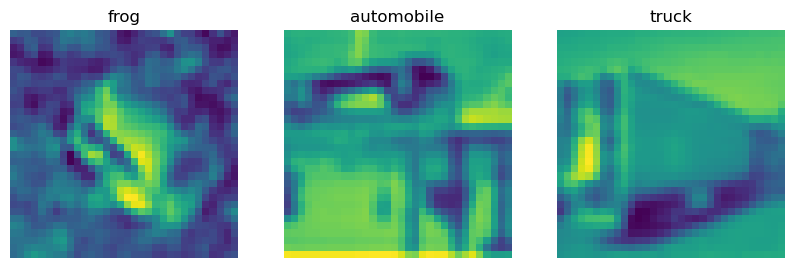

In [82]:
Data_Sample = next(iter(Train_Data))
print('Shape of a batch of images:', Data_Sample[0].shape)

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
for j in range(3):
    idx = np.random.randint(0, len(CIFAR_Train))
    img = CIFAR_Train[idx][0]
    ax[j].imshow(img.permute(1, 2, 0))
    ax[j].set_title(Meta['label_names'][CIFAR_Train[idx][1]])
    ax[j].axis('off')
plt.show()

## 4. NeuralNetwork

In [84]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = torch.nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = nn.functional.log_softmax(out, dim=1)
        return out
    
model = ConvNet()
print(model)

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d

## 5. Train

**Gain:**\
`inputs.view(inputs.size(0), -1)` 这一行代码的作用是将输入数据 `inputs` 从任意形状展平成一维张量。`-1` 的意思是 PyTorch 会自动根据其他维度的大小来推断展平后的维度。这种操作在全连接层之前常常需要，因为全连接层的输入通常是一维的。

然而，在卷积神经网络 (Convolutional Neural Network, CNN) 中，输入数据的形状通常是 `(batch_size, channels, height, width)`，而不是一维的。如果你在模型中使用了卷积层，你需要保持输入数据的形状是这样的。

错误的根本原因是在使用 `model(inputs)` 时，模型期望的是卷积层期望的输入形状，而实际的输入形状却是被压平的。

上面我给出的修改代码是为了将数据的形状调整为卷积层期望的形状 `(batch_size, channels, height, width)`，以适应你的卷积神经网络模型。请根据你的实际情况调整这些维度。

In [52]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs/CNN')

# Constants
EPOCHS = 20
LR = 0.001

def train(model):
    model.train()
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0, amsgrad=False)
    
    for epoch in range(EPOCHS):

        # initial
        sum_loss = 0.0
        train_correct = 0.0
        start_time = time.time()

        for i, data in enumerate(Train_Data):
            inputs, labels = data
            if CUDA:
                inputs, labels = inputs.cuda(), labels.cuda()

            # Optimal inputs size: (batch_size, channels, height, width)
            #                      (64, 3, 32, 32)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        end_time = time.time()
        execution_time = end_time - start_time

        # Calculate average loss and accuracy for the epoch
        avg_loss = sum_loss / len(Train_Data.dataset)
        avg_acc = train_correct / len(Train_Data.dataset)

        # Write to TensorBoard
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Accuracy/train', avg_acc, epoch)

        print('Epoch: {} Loss: {:.6f} Acc: {:.6f} Time: {:.3f}'\
              .format(epoch + 1, avg_loss, avg_acc, execution_time))
    
    print('Finished Training')
    writer.close()


In [97]:
for data in Train_Data:
    inputs, labels = data
    print(labels.shape)  # 检查标签的形状

torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64

In [85]:
model = ConvNet()

if CUDA:
    model = model.cuda()
train(model)

# Save the model checkpoint
torch.save(model.state_dict(), './model/CNN.pth')

Epoch: 1 Loss: 0.025782 Acc: 0.402120 Time: 20.825
Epoch: 2 Loss: 0.020913 Acc: 0.524860 Time: 18.987
Epoch: 3 Loss: 0.019171 Acc: 0.567260 Time: 20.862
Epoch: 4 Loss: 0.018072 Acc: 0.592100 Time: 21.480
Epoch: 5 Loss: 0.017189 Acc: 0.614300 Time: 20.794
Epoch: 6 Loss: 0.016626 Acc: 0.628280 Time: 21.523
Epoch: 7 Loss: 0.016142 Acc: 0.639360 Time: 21.082
Epoch: 8 Loss: 0.015632 Acc: 0.651340 Time: 21.143
Epoch: 9 Loss: 0.015317 Acc: 0.658780 Time: 20.821
Epoch: 10 Loss: 0.015037 Acc: 0.666220 Time: 22.821
Epoch: 11 Loss: 0.014688 Acc: 0.674280 Time: 20.612
Epoch: 12 Loss: 0.014397 Acc: 0.681040 Time: 22.019
Epoch: 13 Loss: 0.014073 Acc: 0.689060 Time: 20.333
Epoch: 14 Loss: 0.013868 Acc: 0.693620 Time: 20.493
Epoch: 15 Loss: 0.013749 Acc: 0.695940 Time: 20.100
Epoch: 16 Loss: 0.013446 Acc: 0.705360 Time: 19.930
Epoch: 17 Loss: 0.013219 Acc: 0.708860 Time: 20.233
Epoch: 18 Loss: 0.013048 Acc: 0.712120 Time: 20.087
Epoch: 19 Loss: 0.012899 Acc: 0.715520 Time: 19.926
Epoch: 20 Loss: 0.012

### Record:

1. Origin 3 layers CNN
```text
Epoch: 16 Loss: 0.016431 Acc: 62.880000 Time: 20.804
Epoch: 17 Loss: 0.016272 Acc: 63.296000 Time: 20.235
Epoch: 18 Loss: 0.016106 Acc: 63.846000 Time: 21.152
Epoch: 19 Loss: 0.015824 Acc: 64.322000 Time: 18.621
Epoch: 20 Loss: 0.015763 Acc: 64.666000 Time: 20.579
```

2. 5 layers CNN with BN
```text
Epoch: 16 Loss: 0.010760 Acc: 75.670000 Time: 21.312
Epoch: 17 Loss: 0.010581 Acc: 76.128000 Time: 21.635
Epoch: 18 Loss: 0.010377 Acc: 76.746000 Time: 22.356
Epoch: 19 Loss: 0.010248 Acc: 76.948000 Time: 21.549
Epoch: 20 Loss: 0.010058 Acc: 77.544000 Time: 21.471
```

3. 5 layers CNN with BN Dropout Softmax LR = 0.002
```text
Epoch: 16 Loss: 0.013222 Acc: 71.292000 Time: 21.861
Epoch: 17 Loss: 0.012902 Acc: 71.902000 Time: 21.849
Epoch: 18 Loss: 0.012691 Acc: 72.268000 Time: 21.877
Epoch: 19 Loss: 0.012457 Acc: 72.876000 Time: 21.781
Epoch: 20 Loss: 0.012290 Acc: 73.006000 Time: 21.507
```

In [90]:
# Use KNN to predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Constants
K = 5

def test(model):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    test_loss = 0.0
    test_correct = 0.0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for i, data in enumerate(Test_Data):
            inputs, labels = data
            if CUDA:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            y_pred += predicted.tolist()
            y_true += labels.tolist()
            print('Batch: ', i, 'Acc: {:.6f}'.format((predicted == labels).sum().item() / len(labels)))

    avg_loss = test_loss / len(Test_Data.dataset)
    avg_acc = test_correct / len(Test_Data.dataset)
    print('Loss: {:.6f} Acc: {:.6f}'.format(avg_loss, avg_acc))
    
    return y_pred, y_true

y_pred, y_true = test(model)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * accuracy_score(y_true, y_pred)))

Batch:  0 Acc: 0.718750
Batch:  1 Acc: 0.640625
Batch:  2 Acc: 0.671875
Batch:  3 Acc: 0.687500
Batch:  4 Acc: 0.703125
Batch:  5 Acc: 0.750000
Batch:  6 Acc: 0.562500
Batch:  7 Acc: 0.703125
Batch:  8 Acc: 0.687500
Batch:  9 Acc: 0.796875
Batch:  10 Acc: 0.625000
Batch:  11 Acc: 0.656250
Batch:  12 Acc: 0.625000
Batch:  13 Acc: 0.609375
Batch:  14 Acc: 0.671875
Batch:  15 Acc: 0.796875
Batch:  16 Acc: 0.625000
Batch:  17 Acc: 0.640625
Batch:  18 Acc: 0.656250
Batch:  19 Acc: 0.578125
Batch:  20 Acc: 0.625000
Batch:  21 Acc: 0.671875
Batch:  22 Acc: 0.656250
Batch:  23 Acc: 0.640625
Batch:  24 Acc: 0.640625
Batch:  25 Acc: 0.640625
Batch:  26 Acc: 0.593750
Batch:  27 Acc: 0.609375
Batch:  28 Acc: 0.687500
Batch:  29 Acc: 0.718750
Batch:  30 Acc: 0.562500
Batch:  31 Acc: 0.640625
Batch:  32 Acc: 0.687500
Batch:  33 Acc: 0.656250
Batch:  34 Acc: 0.703125
Batch:  35 Acc: 0.640625
Batch:  36 Acc: 0.671875
Batch:  37 Acc: 0.734375
Batch:  38 Acc: 0.640625
Batch:  39 Acc: 0.484375
Batch:  40

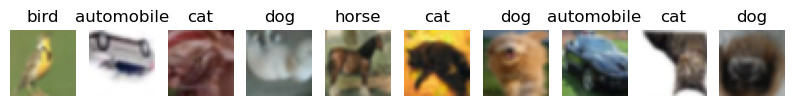

Predicted:    cat   cat   cat   cat   cat   cat   cat   cat   cat   cat
GroundTruth:   bird automobile   cat   dog horse   cat   dog automobile   cat   dog
Softmax:  [3 3 3 3 3 3 3 3 3 3]


In [78]:
from torch.utils.data import Subset
mini_dataset = Subset(CIFAR_Train, range(990, 1000))
# show images
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for j in range(10):
    img = mini_dataset[j][0]
    ax[j].imshow(img.permute(1, 2, 0))
    ax[j].set_title(Meta['label_names'][mini_dataset[j][1]])
    ax[j].axis('off')
plt.show()
mini_dataloader = DataLoader(mini_dataset, batch_size=10, shuffle=False)

if CUDA:
    model = model.cuda()
model.eval()
with torch.no_grad():
    for data in mini_dataloader:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        print('Predicted: ', ' '.join('%5s' % Meta['label_names'][predicted[j]]
                                      for j in range(10)))
        print('GroundTruth: ', ' '.join('%5s' % Meta['label_names'][labels[j]]
                                        for j in range(10)))
        # Softmax
        softmax = torch.exp(outputs).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob, axis=1)
        print('Softmax: ', predictions)

## 6. Tensorboard

In [26]:
from tensorboard import notebook
notebook.display(port=6006, height=1000)
%tensorboard --logdir "log" --host=127.0.0.1

UsageError: Line magic function `%tensorboard` not found.
